In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dill 
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D
from scipy.stats import wilcoxon
import pickle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, cross_val_predict
from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, classification_report, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

<font size="6">    <b>Probability over time</b>

Now we will attempt to fix this thing:
    
    - Extract the epoch and the data on which we will train then test the classifier
    - Extract the features on all the epochs and data of interest
    - Train the LDA with 70% of the features
    - Test the LDA with the other 30%

In [3]:
velocity = pd.read_csv('/Users/willy/Documents/GitHub/2021-fastReach/data/study/ICA/11/\motion.csv', header = None)
eeg = pd.read_csv('/Users/willy/Documents/GitHub/2021-fastReach/data/study/ICA/11/\eeg.csv', header = None)
emg = pd.read_csv('/Users/willy/Documents/GitHub/2021-fastReach/data/study/ICA/11/\emg.csv', header = None)

np.save('/Users/willy/Documents/GitHub/2021-fastReach/data/study/ICA/11//NPYeeg.npy', eeg)
np.save('/Users/willy/Documents/GitHub/2021-fastReach/data/study/ICA/11//NPYemg.npy', emg)
np.save('/Users/willy/Documents/GitHub/2021-fastReach/data/study/ICA/11//NPYvelo.npy', velocity)

In [38]:
chan = pd.read_csv('/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/11/\chans_rp-win_-1-0.csv', header=None)
move = pd.read_csv('/Users/willy/Documents/GitHub/2021-fastReach/data/study/ICA/11/\motion_onset_event_latencies.csv', header = None)
move = move.values[0]
end  = pd.read_csv('/Users/willy/Documents/GitHub/2021-fastReach/data/study/ICA/11/\idle_event_latencies.csv', header = None)
end  = end.values[0]


In [61]:
emg  = np.load('/Users/willy/Documents/GitHub/2021-fastReach/data/study/ICA/11//NPYemg.npy')
eeg_b  = np.load('/Users/willy/Documents/GitHub/2021-fastReach/data/study/ICA/11//NPYeeg.npy')
velo = np.load('/Users/willy/Documents/GitHub/2021-fastReach/data/study/ICA/11//NPYvelo.npy')

# EEG best chan
eeg = []
for i in chan.iloc[1:,0].astype(int)-1:  
    eeg.append(eegb[i,:])
eeg = np.asarray(eeg)

# EMG baseline correction
emg[1,:] = emg[1,:] - np.mean(emg[1, :])
emg[0,:] = emg[0,:] - np.mean(emg[0, :])


<font size="3">    <b>Velocity: Extraction of area of interest</b>

In [15]:
# The first and last onsets do not have enough samples before or after to get a proper frame extraction.
fs = 250

before = fs * 2 +1
after  = fs * 1//2

veloc   = np.zeros((len(move), (before + after)))

for k in range(len(move)):
    
        veloc[k, :(before + after)] = velo[0, move[k] - before : move[k] + after]

<font size="3" color='blue'>    <b>EMG: Epochs extraction and extraction of area of interest</b>

In [16]:
# Number of sample before and after movement onset
idleb_emg   = fs * 2
idlea_emg   = fs * (-1)

intentb_emg = fs
intenta_emg = 0

interb_emg  = fs * 3     # ALWAYS TAKE 250 SAMPLES MORE BEFORE THE DESIRED START
intera_emg  = after

# Let's create matrices with row = epoch, columns = epoch duration and 3D = nb_chan
idle_emg    = np.zeros((len(move), (idleb_emg + idlea_emg),    emg.shape[0]))      # Idle period
intent_emg  = np.zeros((len(move), (intentb_emg + intenta_emg),emg.shape[0]))      # Intention period
inter_emg   = np.zeros((len(move), (interb_emg + intera_emg),  emg.shape[0]))      # Period of interest

for k in range(len(move)):
   
    for j in range(emg.shape[0]):
    
        idle_emg[k, 0:(idleb_emg + idlea_emg), j]       = emg[j, move[k] - idleb_emg : move[k] + idlea_emg]
        intent_emg[k, 0:(intentb_emg + intenta_emg), j] = emg[j, move[k] - intentb_emg : move[k] + intenta_emg]
        inter_emg[k, 0:(interb_emg + intera_emg), j]    = emg[j, move[k] - interb_emg : move[k] + intera_emg]

In [17]:
def rms(values):
    return np.sqrt(sum(values**2)/len(values))

def mini(values):
    return np.min(values)

def maxi(values):
    return np.max(values)

def mav(values):
    return np.mean(abs(values))

def var(values):
    return np.var(values)

feat_list = [rms, mini, maxi, mav, var]

<font size="3" color='blue'>    <b>Extract the features for idle and intent</b>
    
10 features per onset.

In [18]:
win = 250
sld_size = 1

feat_idle   = np.zeros((len(move), emg.shape[0]*len(feat_list)))
feat_intent = np.zeros((len(move), emg.shape[0]*len(feat_list)))                  

for k in range(len(move)):              # Index of the onset
   
    for j in range(emg.shape[0]):    # Index of the channel
        
        for i in range(len(feat_list)): # Index of the feature
        
            feat_idle[k, i +(5*j)]   = np.apply_along_axis(feat_list[i], 0, idle_emg[k, :, j])
            feat_intent[k, i +(5*j)] = np.apply_along_axis(feat_list[i], 0, intent_emg[k, :, j])

<font size="3" color='blue'>    <b>Extract the features on period of interest with a sliding window</b>

In [19]:
feat_inter = np.zeros((len(move), emg.shape[0]*len(feat_list), (inter_emg.shape[1]//sld_size) - fs + sld_size))

for k in range(len(move)):                  # Index of the onset
    
    for l in range(feat_inter.shape[2]):    # Index of the slide
   
        for j in range(emg.shape[0]):    # Index of the channel
        
            for i in range(len(feat_list)): # Index of the feature
        
                feat_inter[k, i +(5*j), l] = np.apply_along_axis(feat_list[i], 0, 
                                                                 inter_emg[k, (sld_size*l):win+(sld_size*l), j])
        

<font size="3" color='blue'>    <b>DataFrame and LDA training</b>

In [52]:
test         = 105
idle_emg     = pd.concat([pd.DataFrame(feat_idle), pd.DataFrame(np.zeros((len(move))))], axis=1, keys={'features', 'class'})
intent_emg   = pd.concat([pd.DataFrame(feat_intent), pd.DataFrame(np.ones((len(move))))], axis=1, keys={'features', 'class'})

df_emg_train = pd.concat([idle_emg.iloc[:test,:], intent_emg.iloc[:test,:]], axis=0) # Only train on 110 first epochs

In [53]:
Xemg    = df_emg_train.iloc[:, :10].values
yemg    = df_emg_train.iloc[:, 10].values
clf_emg = LDA(solver='lsqr', shrinkage='auto')

clf_emg.fit(Xemg, yemg)

# splits data randomly in n=folds 
kfolds = KFold(n_splits=10, random_state=1, shuffle=True)

pred_y_emg = cross_val_predict(clf_emg, Xemg, yemg, cv=kfolds) #For confusion matrix

#For averaged classification metrics
np.save('X_emg_11.npy', Xemg)
np.save('y_emg_11.npy', yemg)
pickle.dump(clf_emg, open('clf_emg_11', 'wb'))
np.save('pred_y_emg_11.npy', pred_y_emg)

cv_results = cross_val_score(clf_emg, Xemg, yemg, cv=kfolds)
cv_average = cv_results.mean()
st_deviation = cv_results.std()
print(cv_average)
print(st_deviation)

0.8333333333333334
0.06116777418411966


<font size="3" color='blue'>    <b>Probability extraction</b>

In [22]:
proba_emg = np.zeros((len(move)-test, feat_inter.shape[2]))

for k in range(len(move)-test):
    
    for l in range(feat_inter.shape[2]):
        
        proba_emg[k, l] = clf_emg.predict_proba(feat_inter[-k, :, l].reshape(1, -1))[0][1]

<font size="3" color='blue'>    <b>DataFrame including Time, Velocity and Proba</b>

In [24]:
time = np.arange(-2-1/fs, 1/2, 1/fs)                       # Define time axis
m_time = np.tile(time, (1, len(move)-test)).transpose()
f_time = np.reshape(m_time, len(m_time))

f_proba_emg = np.reshape(proba_emg, len(f_time))

m_velo = veloc[test:, :]
f_velocity = np.reshape(m_velo, len(f_time))

f_data_emg = np.zeros((len(f_time), 3))
f_data_emg[:,0] = f_time
f_data_emg[:,1] = f_velocity * 1000
f_data_emg[:,2] = f_proba_emg
final_emg = pd.DataFrame(f_data_emg, columns=['Time', 'Velocity', 'Probability'])
final_emg

,Time,Velocity,Probability
0,-2.004,0.017220,0.964296
1,-2.000,0.016950,0.964346
2,-1.996,0.016603,0.964296
3,-1.992,0.015891,0.964417
4,-1.988,0.015102,0.964407
...,...,...,...
28165,0.480,2.082489,1.000000
28166,0.484,2.046503,1.000000
28167,0.488,2.012621,1.000000
28168,0.492,1.981039,1.000000


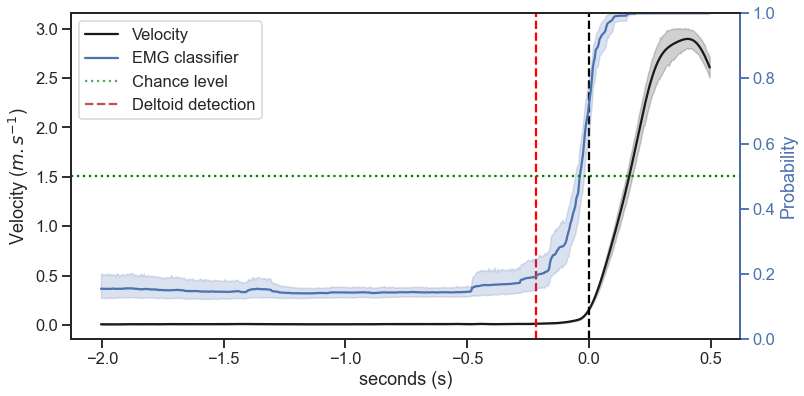

In [25]:
figure(figsize=(12, 6))

# Velocity
sns.set_theme(context='talk', style='ticks')
ep_move = sns.lineplot(data=final_emg, x='Time', y='Velocity', color='k', legend=False)

ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

# Movement onset
plt.axvline(0, color='black', label = 'onset', linestyle ='--')

# Detection onset
plt.axvline(-0.216,
            color='red', label = 'onset', linestyle ='--')

# Probability
ax2 = plt.twinx()
ax2.set_ylabel('Probability', color='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')
ep_prob = sns.lineplot(data=final_emg, x='Time', y='Probability', ax=ax2, color='b', legend=False)
plt.ylim((0,1))
plt.axhline(0.5, color='green', label = 'onset', linestyle ='dotted')

# legend
ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
                                          Line2D([], [], marker='_', color="b", label='EMG classifier'),
                                          Line2D([], [], linestyle ='dotted', color="g", label='Chance level'),
                                          Line2D([], [], linestyle ='--', color="r", label='Deltoid detection')])

<font size="3" color='red'>    <b>EEG: Epochs extraction and extraction of area of interest</b>

In [62]:
# Number of sample before and after movement onset
idleb_eeg   = fs * 0
idlea_eeg   = fs * 1

intentb_eeg = fs
intenta_eeg = 0

interb_eeg  = fs * 3
intera_eeg  = after

# Let's create matrices with row = epoch, columns = epoch duration and 3D = nb_chan
idle_eeg    = np.zeros((len(end), (idleb_eeg + idlea_eeg),    eeg.shape[0]))       # Idle period
intent_eeg  = np.zeros((len(move), (intentb_eeg + intenta_eeg),eeg.shape[0]))      # Intention period
inter_eeg   = np.zeros((len(move), (interb_eeg + intera_eeg),  eeg.shape[0]))      # Period of interest

for l in range(len(end)):
    for k in range(len(move)):
   
        for j in range(eeg.shape[0]):
    
            idle_eeg[l, 0:(idleb_eeg + idlea_eeg), j]       = eeg[j, end[l] - idleb_eeg : end[l] + idlea_eeg]
            intent_eeg[k, 0:(intentb_eeg + intenta_eeg), j] = eeg[j, move[k] - intentb_eeg : move[k] + intenta_eeg]
            inter_eeg[k, 0:(interb_eeg + intera_eeg), j]    = eeg[j, move[k] - interb_eeg : move[k] + intera_eeg]

<font size="3" color='red'>    <b>Feature extration on idle and intent</b>

In [65]:
win       = 250
sld_size  = 1
feat_size = 25
n_feat    = win//feat_size

feat_idle_eeg   = np.zeros((len(end), eeg.shape[0]*n_feat))
feat_intent_eeg = np.zeros((len(move), eeg.shape[0]*n_feat))                  

for l in range(len(end)):
   
    for j in range(eeg.shape[0]):     # Index of the channel
        
         for i in range(n_feat):         # Index of the feature
                
                feat_idle_eeg[l, i +(n_feat*j)]   = np.mean(idle_eeg[l, (feat_size*i):feat_size + (feat_size*i), j])
        
for k in range(len(move)):              # Index of the onset
   
    for j in range(eeg.shape[0]):     # Index of the channel
        
         for i in range(n_feat):         # Index of the feature
        
                feat_intent_eeg[k, i +(n_feat*j)] = np.mean(intent_eeg[k, (feat_size*i):feat_size + (feat_size*i), j])

<font size="3" color='red'>    <b>Feature extraction on area on interest with sliding window</b>

In [66]:
feat_inter_eeg = np.zeros((len(move), eeg.shape[0]*n_feat, (inter_eeg.shape[1]//sld_size) - fs + sld_size))

for k in range(len(move)):                   # Index of the onset
    
    for l in range(feat_inter_eeg.shape[2]): # Index of the slide
   
        for j in range(eeg.shape[0]):      # Index of the channel
            
            for i in range(n_feat):          # Index of the feature
        
                feat_inter_eeg[k, i +(n_feat*j), l] = np.mean(inter_eeg[k, 
                                                  (feat_size*i)+(sld_size*l):feat_size + 
                                                  (feat_size*i)+(sld_size*l), j])


<font size="3" color='red'>    <b>Baseline correction CHECK THIS AGAIN WITH FRESH BRAIN</b>

In [67]:
#Correct the baseline after mean feature extraction, I think it should work that way
idle_cor   = np.zeros((feat_idle_eeg.shape))
intent_cor = np.zeros((feat_intent_eeg.shape))
inter_cor  = np.zeros((feat_inter_eeg.shape))

for k in range(len(end)):
    
    for j in range(eeg.shape[0]):
            
        idle_cor[k, (10*j):10+(10*j)]   = feat_idle_eeg[k, (10*j):10+(10*j)] - idle_eeg[k, 0, j]

for k in range(len(move)):
    
    for j in range(eeg.shape[0]):

        intent_cor[k, (10*j):10+(10*j)] = feat_intent_eeg[k, (10*j):10+(10*j)] - intent_eeg[k, 0, j]
            
        for l in range(feat_inter_eeg.shape[2]):
            
            inter_cor[k, (10*j):10+(10*j), l] = feat_inter_eeg[k, (10*j):10+(10*j), l] - inter_eeg[k, l, j]
        

<font size="3" color='red'>    <b>DataFrames</b>

In [68]:
test       = (len(move)*70)//100
idle_eeg   = pd.concat([pd.DataFrame(idle_cor), pd.DataFrame(np.zeros((145)))], axis=1, keys={'features', 'class'})
intent_eeg = pd.concat([pd.DataFrame(intent_cor), pd.DataFrame(np.ones((150)))], axis=1, keys={'features', 'class'})

df_eeg_train = pd.concat([idle_eeg.iloc[:test,:], intent_eeg.iloc[:test,:]], axis=0) 

<font size="3" color='red'>    <b>Classifier training</b>

In [69]:
Xeeg = df_eeg_train.iloc[:, :-1].values
yeeg = df_eeg_train.iloc[:, -1].values

clf_eeg = LDA(solver='lsqr', shrinkage='auto')

clf_eeg.fit(Xeeg, yeeg)

# splits data randomly in n=folds 
kfolds = KFold(n_splits=10, random_state=1, shuffle=True)

pred_y_eeg = cross_val_predict(clf_eeg, Xeeg, yeeg, cv=kfolds) #For confusion matrix

#For averaged classification metrics
np.save('X_eeg_11.npy', Xeeg)
np.save('y_eeg_11.npy', yeeg)
pickle.dump(clf_eeg, open('clf_eeg_11', 'wb'))
np.save('pred_y_eeg_11.npy', pred_y_eeg)

cv_results = cross_val_score(clf_eeg, Xeeg, yeeg, cv=kfolds)
cv_average = cv_results.mean()
st_deviation = cv_results.std()
print(cv_average)
print(st_deviation)

0.8809523809523808
0.08844845533812719


<font size="3" color='red'>    <b>Probability testing</b>

In [70]:
proba_eeg = np.zeros((len(move)-test, feat_inter_eeg.shape[2]))

for k in range(len(move)-test):
    
    for l in range(feat_inter_eeg.shape[2]):
        
        proba_eeg[k, l] = clf_eeg.predict_proba(inter_cor[-k, :, l].reshape(1, -1))[0][1]

<font size="3" color='red'>    <b>DataFrame, Velocity, Proba</b>

In [71]:
time = np.arange(-2-1/fs, 1/2, 1/fs)                     # Define time axis
m_time = np.tile(time, (1, len(move)-test)).transpose()
f_time = np.reshape(m_time, len(m_time))

f_proba_eeg = np.reshape(proba_eeg, len(f_time))

m_velo = veloc[test:, :]
f_velocity = np.reshape(m_velo, len(f_time))

f_data_eeg = np.zeros((len(f_time), 3))
f_data_eeg[:,0] = f_time
f_data_eeg[:,1] = f_velocity * 1000
f_data_eeg[:,2] = f_proba_eeg
final_eeg = pd.DataFrame(f_data_eeg, columns=['Time', 'Velocity', 'Probability'])
final_eeg

,Time,Velocity,Probability
0,-2.004,0.017220,0.018702
1,-2.000,0.016950,0.042087
2,-1.996,0.016603,0.025413
3,-1.992,0.015891,0.086583
4,-1.988,0.015102,0.017805
...,...,...,...
28165,0.480,2.082489,0.999998
28166,0.484,2.046503,0.999936
28167,0.488,2.012621,0.999868
28168,0.492,1.981039,0.999940


<font size="3" color='red'>    <b>Plot</b>

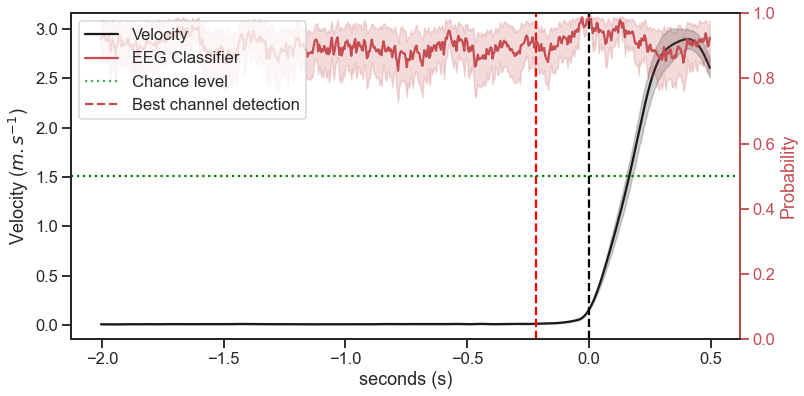

In [72]:
figure(figsize=(12, 6))

# Velocity
sns.set_theme(context='talk', style='ticks')
ep_move = sns.lineplot(data=final_eeg, x='Time', y='Velocity', color='k', legend=False)

ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

# Movement onset
plt.axvline(0, color='black', label = 'onset', linestyle ='--')

# Detection onset
plt.axvline(-0.216,
            color='red', label = 'onset', linestyle ='--')

# Probability
ax2 = plt.twinx()
ax2.set_ylabel('Probability', color='r')
ax2.spines['right'].set_color('r')
ax2.tick_params(axis='y', colors='r')
ep_prob = sns.lineplot(data=final_eeg, x='Time', y='Probability', ax=ax2, color='r', legend=False)
plt.ylim((0,1))

plt.axhline(0.5, color='green', label = 'onset', linestyle ='dotted')

# legend
ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
                                          Line2D([], [], marker='_', color="r", label='EEG Classifier'),
                                          Line2D([], [], linestyle ='dotted', color="g", label='Chance level'),
                                          Line2D([], [], linestyle ='--', color="r", label='Best channel detection')])

<font size="3" color='purple'>    <b>Merge for EEG_EMG</b>

In [27]:
idle_eeg_emg   = np.concatenate((feat_idle, idle_cor), axis=1)
intent_eeg_emg = np.concatenate((feat_intent, intent_cor), axis=1)

inter_eeg_emg  = np.concatenate((feat_inter, inter_cor), axis=1)

test   = 105
idle   = pd.concat([pd.DataFrame(idle_eeg_emg), pd.DataFrame(np.zeros((150)))], axis=1, keys={'features', 'class'})
intent = pd.concat([pd.DataFrame(intent_eeg_emg), pd.DataFrame(np.ones((150)))], axis=1, keys={'features', 'class'})

df_eeg_emg_train = pd.concat([idle.iloc[:test,:], intent.iloc[:test,:]], axis=0) 

<font size="3" color='purple'>    <b>Classifier</b>

In [63]:
Xeeg_emg = df_eeg_emg_train.iloc[:, :-1].values
yeeg_emg = df_eeg_emg_train.iloc[:, -1].values

clf_eeg_emg = LDA(solver='lsqr', shrinkage='auto')

clf_eeg_emg.fit(Xeeg_emg, yeeg_emg)

# splits data randomly in n=folds 
kfolds = KFold(n_splits=10, random_state=1, shuffle=True)

pred_y_eeg_emg = cross_val_predict(clf_eeg_emg, Xeeg_emg, yeeg_emg, cv=kfolds) #For confusion matrix

#For averaged classification metrics
np.save('X_eeg_emg_11.npy', Xeeg_emg)
np.save('y_eeg_emg_11.npy', yeeg_emg)
pickle.dump(clf_eeg_emg, open('clf_eeg_emg_11', 'wb'))
np.save('pred_y_eeg_emg11.npy', pred_y_eeg_emg)

cv_results = cross_val_score(clf_eeg_emg, Xeeg_emg, yeeg_emg, cv=kfolds)
cv_average = cv_results.mean()
st_deviation = cv_results.std()
print(cv_average)
print(st_deviation)

0.8095238095238095
0.07377111135633174


<font size="3" color='purple'>    <b>Proba</b>

In [29]:
proba_eeg_emg = np.zeros((len(move)-test, feat_inter_eeg.shape[2]))

for k in range(len(move)-test):
    
    for l in range(feat_inter_eeg.shape[2]):
        
        proba_eeg_emg[k, l] = clf_eeg_emg.predict_proba(inter_eeg_emg[-k, :, l].reshape(1, -1))[0][1]

<font size="3" color='purple'>    <b>DataFrame</b>

In [30]:
time = np.arange(-2-1/fs, 1/2, 1/fs)                       # Define time axis
m_time = np.tile(time, (1, len(move)-test)).transpose()
f_time = np.reshape(m_time, len(m_time))

f_proba_eeg_emg = np.reshape(proba_eeg_emg, len(f_time))

m_velo = veloc[test:, :]
f_velocity = np.reshape(m_velo, len(f_time))

f_data_eeg_emg = np.zeros((len(f_time), 3))
f_data_eeg_emg[:,0] = f_time
f_data_eeg_emg[:,1] = f_velocity * 1000
f_data_eeg_emg[:,2] = f_proba_eeg_emg
final_eeg_emg = pd.DataFrame(f_data_eeg_emg, columns=['Time', 'Velocity', 'Probability'])
final_eeg_emg

,Time,Velocity,Probability
0,-2.004,0.017220,0.875494
1,-2.000,0.016950,0.935462
2,-1.996,0.016603,0.970890
3,-1.992,0.015891,0.994342
4,-1.988,0.015102,0.996305
...,...,...,...
28165,0.480,2.082489,0.423057
28166,0.484,2.046503,0.458117
28167,0.488,2.012621,0.828541
28168,0.492,1.981039,0.930766


<font size="3" color='purple'>    <b>Plot</b>

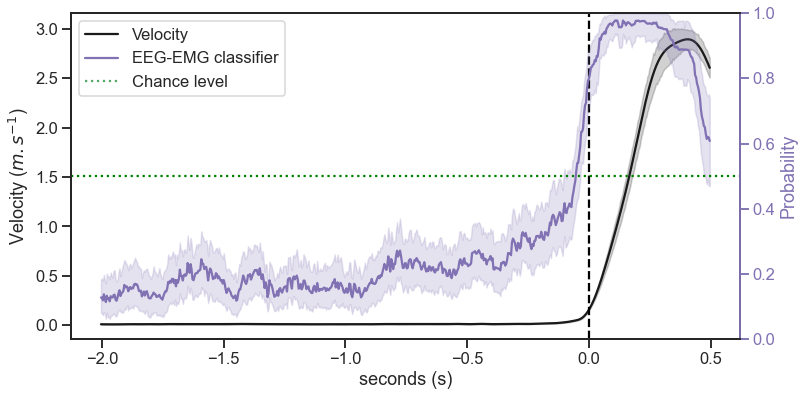

In [31]:
figure(figsize=(12, 6))

# Velocity
sns.set_theme(context='talk', style='ticks')
ep_move = sns.lineplot(data=final_eeg_emg, x='Time', y='Velocity', color='k', legend=False)

ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

# Movement onset
plt.axvline(0, color='black', label = 'onset', linestyle ='--')

# Probability
ax2 = plt.twinx()
ax2.set_ylabel('Probability', color='m')
ax2.spines['right'].set_color('m')
ax2.tick_params(axis='y', colors='m')
ep_prob = sns.lineplot(data=final_eeg_emg, x='Time', y='Probability', ax=ax2, color='m', legend=False)
plt.ylim((0,1))
plt.axhline(0.5, color='green', label = 'onset', linestyle ='dotted')

# legend
ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
                                          Line2D([], [], marker='_', color="m", label='EEG-EMG classifier'),
                                          Line2D([], [], linestyle ='dotted', color="g", label='Chance level')])

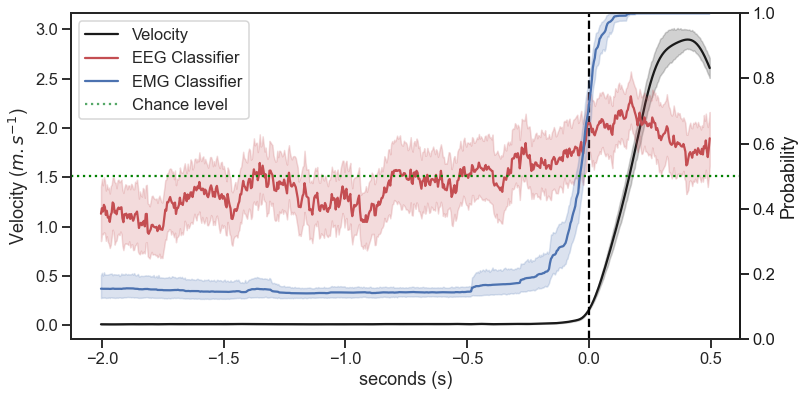

In [32]:
figure(figsize=(12, 6))

# Velocity
sns.set_theme(context='talk', style='ticks')
ep_move = sns.lineplot(data=final_eeg, x='Time', y='Velocity', color='k', legend=False)

ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

# Movement onset
plt.axvline(0, color='black', label = 'onset', linestyle ='--')

# Probability
ax2 = plt.twinx()
ax2.set_ylabel('Probability', color='k')
ax2.spines['right'].set_color('k')
ax2.tick_params(axis='y', colors='k')
ep_prob = sns.lineplot(data=final_eeg, x='Time', y='Probability', ax=ax2, color='r', legend=False)
ep_prob_2 = sns.lineplot(data=final_emg, x='Time', y='Probability', ax=ax2, color='b', legend=False)
plt.ylim((0,1))

plt.axhline(0.5, color='green', label = 'onset', linestyle ='dotted')

# legend
ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
                                          Line2D([], [], marker='_', color="r", label='EEG Classifier'),
                                          Line2D([], [], marker='_', color="b", label='EMG Classifier'),
                                          Line2D([], [], linestyle ='dotted', color="g", label='Chance level')])

<font size="3" color='blue'>    <b>Let's try to represent few trails in a row only</b>
    
    -Get a part of the continuous stream of EMG and Velocity data
    -Extract the features on the sliding window
    -Extract the proba
    -DataFrame and plot

In [33]:
# 3 trials period
trials = move[len(move)//2:len(move)//2+3] # Take 3 onsets in the middle of the array

beforet = (fs * 2) +1
aftert  =  fs * 2

interb_temg  = fs * 3                       # ALWAYS TAKE 250 SAMPLES MORE BEFORE THE DESIRED START
intera_temg  = fs * 2

inter_velo = np.zeros(((trials[-1] + aftert) - (trials[0] - beforet)))
inter_temg = np.zeros((emg.shape[0], (trials[-1] + intera_temg) - (trials[0] - interb_temg)))

inter_velo       = veloc[0, (trials[0] - beforet):(trials[-1] + aftert)]
inter_temg[0, :] = emg[0, (trials[0] - interb_temg):(trials[-1] + intera_temg)]
inter_temg[1, :] = emg[1, (trials[0] - interb_temg):(trials[-1] + intera_temg)]

In [34]:
# Feature extraction

feat_trial_emg = np.zeros((emg.shape[0] * len(feat_list), inter_temg.shape[1] - win + sld_size))
    
for l in range(feat_trial_emg.shape[1]):    # Index of the slide
   
    for j in range(emg.shape[0]):    # Index of the channel
        
        for i in range(len(feat_list)): # Index of the feature
        
                feat_trial_emg[i +(5*j), l] = np.apply_along_axis(feat_list[i], 0, 
                                                                 inter_temg[j, (sld_size*l):win+(sld_size*l)])
        

In [35]:
# Probability

proba_trial_emg = np.zeros((feat_trial_emg.shape[1]))

for l in range(feat_trial_emg.shape[1]):

    proba_trial_emg[l] = clf_emg.predict_proba(feat_trial_emg[:, l].reshape(1, -1))[0][1]

In [36]:
time = np.arange((trials[0] - beforet)/fs, (trials[-1] + aftert)/fs -1/fs, 1/fs).transpose()                   # Define time axis
#f_time = np.reshape(m_time, len(m_time))

In [39]:
df_trial_emg = np.zeros((len(time), 3))
df_trial_emg[:,0] = time
df_trial_emg[:,1] = inter_velo * 1000
df_trial_emg[:,2] = proba_trial_emg
df_trial_emg = pd.DataFrame(df_trial_emg, columns=['Time', 'Velocity', 'Probability'])
df_trial_emg

,Time,Velocity,Probability
0,1489.648,0.008270,0.110614
1,1489.652,0.007724,0.110726
2,1489.656,0.007826,0.109726
3,1489.660,0.008471,0.109565
4,1489.664,0.009376,0.109538
...,...,...,...
7878,1521.160,2.338271,0.915617
7879,1521.164,2.309899,0.922033
7880,1521.168,2.279832,0.902040
7881,1521.172,2.248266,0.883627


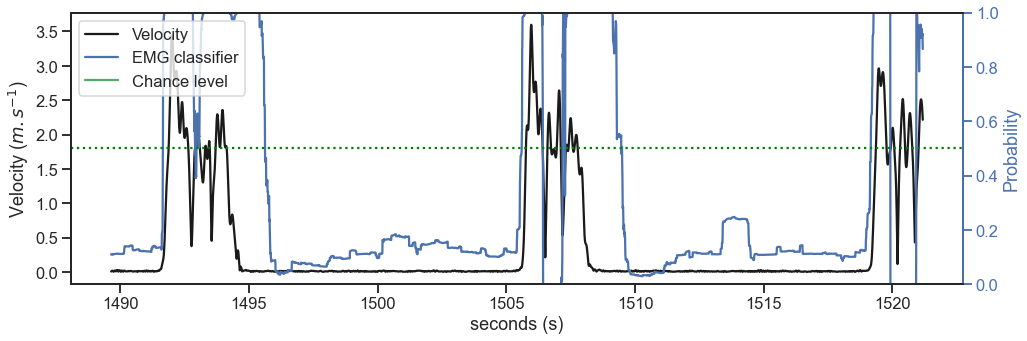

In [40]:
figure(figsize=(16, 5))

# Velocity
sns.set_theme(context='talk', style='ticks')
ep_move = sns.lineplot(data=df_trial_emg, x='Time', y='Velocity', color='k', legend=False)

ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

# Probability
ax2 = plt.twinx()
ax2.set_ylabel('Probability', color='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')
ep_prob = sns.lineplot(data=df_trial_emg, x='Time', y='Probability', ax=ax2, color='b', legend=False)
plt.ylim((0,1))
plt.axhline(0.5, color='green', label = 'onset', linestyle ='dotted')

# legend
ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
                                          Line2D([], [], marker='_', color="b", label='EMG classifier'), 
                                          Line2D([], [], marker='_', color="g", label='Chance level')])